# How have hosts coped with the COVID-19 pandemic in London?

In [224]:
import os
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt, dates
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()

### Get data

The listings dataset from the Inside Airbnb site will be used to analyze the impact of COVID-19 on Airbnb hosts in London. This dataset contains summary information and metrics for Airbnb listings in London.

The data folder contains the listings datasets from February till August 2019 and February till August 2020 (excluding July as the website did not have data for the month of July).

In [225]:
folder = "data"
files = os.listdir(folder)
# Create dataframe combining data from all files
listings_df = pd.concat([pd.read_csv(os.path.join(folder, file)).assign(date=re.search(r"\d+",file)[0]) for file in files], ignore_index=True)

### Preview and Clean data

In [228]:
# This dataframe has 17 columns and 999,091 rows
listings_df.shape

(991091, 17)

In [229]:
listings_df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,21,2020-02-22,0.18,3,361,20200510
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,10,89,2020-03-16,0.70,1,256,20200510


In [230]:
# Drop neighbourhood_group column as it does not contain any information
listings_df.drop(columns="neighbourhood_group", inplace=True)

In [237]:
# 4 columns have missing datapoints: name, host_name, last_review and reviews_per_month
# However, these columns will not be used in this analysis
list(listings_df.columns[listings_df.isnull().sum() > 0])

['name', 'host_name', 'last_review', 'reviews_per_month']

In [238]:
# Update type of date column
listings_df["date"] = pd.to_datetime(listings_df["date"])

## To better undertand how the COVID-19 pandemic impacted Airbnb hosts in London, we will explore the below four questions:
1. Did the number of listings on Airbnb decrease since the start of the pandemic?
2. Did the pandemic impact hosts across London equally?
3. Were there any changes in the types of accommodations listed on the platform?
4. Did hosts try to lower the prices of their listings to encourage renters to book?

### 1. Did the number of listings on Airbnb decrease since the start of the pandemic?

#### Data preparation

In [239]:
# Add month and year columns to listings_df to compare the listings per year 
listings_df["month"] = listings_df["date"].dt.month
listings_df["year"] = listings_df["date"].dt.year

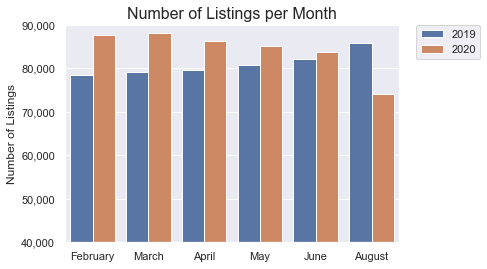

In [269]:
# Plot number of listings per month in 2019 and 2020
months = ["February", "March", "April", "May", "June", "August"]
plot = sns.countplot(x="month", hue="year", data=listings_df, order=sorted(listings_df["month"].unique()), hue_order=[2019,2020]);
# Style plot
plot.set(ylim=(40000, 90000), ylabel="Number of Listings", xlabel=None, xticklabels=months)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);
plt.title(label="Number of Listings per Month", fontsize=16);
plot.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))));


#### Data Evaluation
Although the above barchart shows that there were more Airbnb listings over the Feb-June period in 2020 than in 2019,  we can see a clear downward trend in the number of listings since February compared to an upward trend over the same period last year. August is the month with the lowest listings in 2020. 

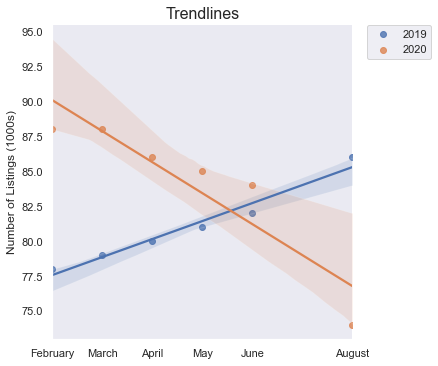

In [249]:
# Plot trendlines for 2019 and 2020 to confirm the above observations (modelling)
listings_count_df = listings_df.groupby(["year","month"]).count()["id"].reset_index()
listings_count_df["id"] = listings_count_df["id"].apply(lambda x: round(x/1000))
graph = sns.lmplot(x="month", y="id", hue="year", data=listings_count_df, legend=False);
# Style graph
graph.set(ylabel="Number of Listings (1000s)", xlabel=None);
plt.xticks([2,3,4,5,6,8], months);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0);
plt.title(label="Trendlines", fontsize=16);
plt.grid(False)

The above plot shows that the number of listings on Airbnb has been decreasing since February 2020. In 2019, during the same period, the number of listings was increasing. 

The data confirms that some hosts did indeed move away from Airbnb. Many articles suggest that hosts are flipping their houses back into the long-term market instead. 

### 2. Did the pandemic impact hosts across London equally?
To answer this question, we will focus on the month of August as it had the largest year-to-year change.

#### Data preparation

In [250]:
# Get number of listings per borough in August 2019 and 2020
listings_per_borough = listings_df[listings_df.month == 8].groupby(["year","neighbourhood"]).count()["id"].unstack(level=0).reset_index()

In [251]:
# Boroughs in london are split into two groups: Inner London boroughs and Outer London Boroughs
inner_boroughs = ["Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington", "Royal Borough of Kensington and Chelsea", "Lambeth", "Lewisham", "Southwark", "Tower Hamlets", "Wandsworth", "Westminster"]
listings_per_borough["Inner Borough"] = np.where(listings_per_borough["neighbourhood"].isin(inner_boroughs), True, False)

In [252]:
# Group listings per London Region (Inner/Outer)
grouped_listings = listings_per_borough.groupby(["Inner Borough"]).sum()
pct_change = grouped_listings.pct_change(axis='columns')[2020]
pct_change_df = pct_change.to_frame().reset_index()
pct_change_df.replace({True: "Inner Boroughs", False: "Outer Boroughs"}, inplace=True)
pct_change_df.columns = ["London Region", "Change"]
pct_change_df

,London Region,Change
0,Outer Boroughs,-0.093148
1,Inner Boroughs,-0.157197


In [248]:
# Style df
pct_change_df.style.format({"Change": "{:.2%}"}).hide_index().set_properties(**{'text-align': 'right'})

London Region,Change
Outer Boroughs,-9.31%
Inner Boroughs,-15.72%


#### Data Evaluation
The above table shows that the listings in Inner London decreased by almost 16% between August 2019 and 2020, almost twice as much as listings in Outer London. It seems like hosts in central London were impacted more than hosts in outer London.

### 3. Were there any changes in the types of accommodations listed on the platform?

#### Data preparation

In [253]:
# Compare number of listings per room type in 2019 and 2020 
listings_df_per_room_type = listings_df.groupby(["year","room_type"]).count()["id"]
df_per_room_type = listings_df_per_room_type.unstack(level=0)
df_per_room_type['percentage_change'] = ((df_per_room_type[2020] - df_per_room_type[2019])/df_per_room_type[2019])
df_per_room_type.columns.name = None
df_per_room_type = df_per_room_type.reset_index()
df_per_room_type.columns = ["Room Type", "2019", "2020", "Change"]
df_per_room_type

,Room Type,2019,2020,Change
0,Entire home/apt,271327,282434,0.040936
1,Hotel room,8,4413,550.625000
2,Private room,210192,214361,0.019834
3,Shared room,4402,3954,-0.101772


In [211]:
def color_values_per_sign(value):
    """Color elements in dateframe green if positive and red if negative."""
    color = "red" if value < 0 else "green"
    return 'color: %s' % color

In [254]:
# Style df
df_per_room_type.style.applymap(color_values_per_sign, subset=['Change']).format({"Change": "{:,.0%}", "2019": "{:,}", "2020": "{:,}"}).hide_index().set_properties(**{'text-align': 'middle'})

Room Type,2019,2020,Change
Entire home/apt,"271,327","282,434",4%
Hotel room,8,"4,413","55,062%"
Private room,"210,192","214,361",2%
Shared room,"4,402","3,954",-10%


#### Data Evaluation
There was no significant change in the number of entire homes/apts nor private rooms between 2019 and 2020. However, the number of hotel rooms on the platform increased significantly. This is quite interesting as most hoteliers saw Airbnb as a threat since it was founded. Also the number of shared rooms decreased by 10%, which is understandable as less people are willing to share rooms with the covid-19 pandemic.

In [256]:
# Filter dataframe to keep Hotel and Shared rooms
filtered_df_per_room_type = listings_df_per_room_type.reset_index()
filtered_df_per_room_type = filtered_df_per_room_type[filtered_df_per_room_type.room_type.isin(['Hotel room', 'Shared room'])]
filtered_df_per_room_type

,year,room_type,id
1,2019,Hotel room,8
3,2019,Shared room,4402
5,2020,Hotel room,4413
7,2020,Shared room,3954


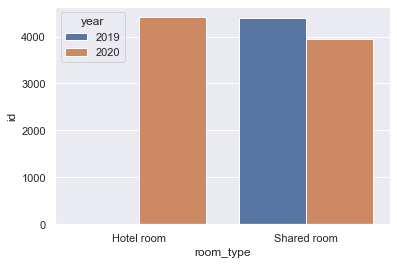

In [258]:
# Plot df to better visualize the above observations
sns.barplot(x="room_type", y="id", data=filtered_df_per_room_type, hue="year");

### 4. Did hosts try to lower the prices of their listings to encourage renters to book?

#### Data preparation

In [260]:
# Filter dataframe to keep only accomodations that were listed in both Feb-Aug 2019 and Feb-Aug 2020 (excl. July)
# This subset was chosen to compare the price changes of the same properties across these two periods
ids = set(listings_df["id"].value_counts()[listings_df["id"].value_counts() == 12].index)
subset_df = listings_df[listings_df["id"].isin(ids)]
subset_df.shape

(451548, 18)

In [261]:
# There are 37,629 accomodations that were listed in both periods of interest
len(ids)

37629

In [262]:
# Get average price per month
pricing_df = subset_df.groupby(["year","month"]).mean()["price"]

In [268]:
# Compare monthly average prices per night between 2019 and 2020
unstacked_pricing_df = pricing_df.unstack(level=0)
unstacked_pricing_df['percentage_change'] = ((unstacked_pricing_df[2020] - unstacked_pricing_df[2019])/unstacked_pricing_df[2019])*100
# Style df
unstacked_pricing_df.style.bar(subset=['percentage_change'], align='mid', color=['#d65f5f', '#5fba7d'])

year,2019,2020,percentage_change
month,,,
2,104.263095,108.423902,3.990680
3,103.885354,108.279146,4.229462
4,103.939329,108.011348,3.917688
5,104.115337,108.052114,3.781170
6,104.682665,107.895612,3.069226
8,105.112307,109.351856,4.033352


#### Data Evaluation
The average monthly prices were at least 3% higher in 2020 than in 2019 over the Feb-August period (excl. July).

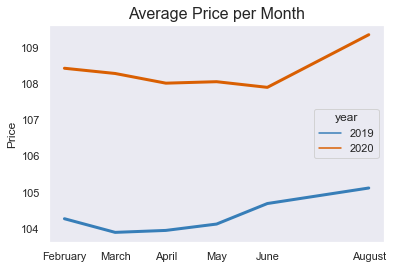

In [267]:
# Plot nighlty average prices per month
lineplot = sns.lineplot(data=pricing_df.reset_index(), x="month", y="price", hue="year", linewidth=3,palette=["#377eb8","#d95f02"]);
# Style plot
lineplot.set(ylabel="Price", xlabel=None);
plt.grid(False)
plt.xticks([2,3,4,5,6,8], months);
plt.title(label="Average Price per Month", fontsize=16);

Although there was a slight negative trend from February till June 2020, it does not seem like there was a substantial impact on the prices of listings since the pandemic started.